In [1]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.preprocessing import OneHotEncoder
import time

from yellowbrick.target import ClassBalance
from imblearn.over_sampling import SMOTE

# Importing preprocessing and modeling libraries
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import tree

# Importing metrics for model evaluation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics

# Importing class balance tools for handling imbalanced datasets
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from yellowbrick.target import ClassBalance

# Importing classifier models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

### Preprocessing the Data

In [2]:
#Reading the CSVs
merged_data = pd.read_csv('all_data.csv')
merged_data.head()

us_counties = gpd.read_file('tl_2022_us_county/tl_2022_us_county.shp')

merged_data = merged_data.merge(us_counties, left_on='RegionName', right_on='NAMELSAD')

merged_data.head()

#Keeping these columns and converting to float
columns_to_float = ['ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON']
merged_data[columns_to_float] = merged_data[columns_to_float].astype(float)

#Filtering for states we wanna deep dive in
filtered_states = merged_data[merged_data['State'].isin(['CO', 'NY', 'CA', "FL", 'IL', 'PA', 'NC', 'TX', 'WA', "NM", "UT"])]


In [3]:
filtered_states.head()

,Unnamed: 0,Date,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),...,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,0,2000-01-31,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,...,G4020,None,None,None,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756..."
1,1,2000-01-31,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,...,G4020,None,None,None,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756..."
2,1566,2000-02-29,2000,2,Los Angeles County,CA,122977.776411,400660.415894,50.6,1.1,...,G4020,None,None,None,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756..."
3,1567,2000-02-29,2000,2,Los Angeles County,CA,122977.776411,400660.415894,50.6,1.1,...,G4020,None,None,None,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756..."
4,3136,2000-03-31,2000,3,Los Angeles County,CA,123487.708531,402315.707957,53.8,1.7,...,G4020,None,None,None,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756..."


### Figuring things out with how to make this into a classification problem

1. Make temperature into a multiclass of 1 = Low, 2 = Medium, and 3 - High in terms of temperature risk based on anomalies

In [4]:
# Define the bins and labels for each class
bins = [-float('inf'), -0.6, 3.4, float('inf')]
labels = [1.0, 2.0, 3.0]  # Corresponding labels for each bin

# Create the multiclass labels using cut function and assign it to a new column
filtered_states['temperature_multiclass'] = pd.cut(filtered_states['Anomaly (1901-2000 base period)'], bins=bins, labels=labels)

# Convert the labels to integer type
filtered_states['temperature_multiclass'] = filtered_states['temperature_multiclass'].astype(int)

# Printing the first few rows to verify
filtered_states.head()

/var/folders/6c/t8_sl0r155q97klcrfwnkw7h0000gn/T/ipykernel_73165/1974828212.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_states['temperature_multiclass'] = pd.cut(filtered_states['Anomaly (1901-2000 base period)'], bins=bins, labels=labels)
/var/folders/6c/t8_sl0r155q97klcrfwnkw7h0000gn/T/ipykernel_73165/1974828212.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_states['temperature_multiclass'] = filtered_states['temperature_multiclass'].astype(int)


,Unnamed: 0,Date,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),...,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,temperature_multiclass
0,0,2000-01-31,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,...,None,None,None,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",3
1,1,2000-01-31,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,...,None,None,None,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",3
2,1566,2000-02-29,2000,2,Los Angeles County,CA,122977.776411,400660.415894,50.6,1.1,...,None,None,None,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",2
3,1567,2000-02-29,2000,2,Los Angeles County,CA,122977.776411,400660.415894,50.6,1.1,...,None,None,None,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",2
4,3136,2000-03-31,2000,3,Los Angeles County,CA,123487.708531,402315.707957,53.8,1.7,...,None,None,None,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",2


### The idea was to make a ratio change/ percentage change of each year of bottom tier home value prices, top tier home value prices, and purchase price 

In [5]:
# Group the data by 'County Name' and calculate the percentage change for each group
filtered_states['Ratio_Change_Bottom_Tier'] = filtered_states.groupby(['RegionName', 'Month', 'Term to Maturity'])['Bottom-Tier Average Home Value Estimate'].pct_change()*100
filtered_states['Ratio_Change_Top_Tier'] = filtered_states.groupby(['RegionName', 'Month', 'Term to Maturity'])['Top-Tier Average Home Value Estimate'].pct_change()*100
filtered_states['Ratio_Change'] = filtered_states.groupby(['RegionName', 'Month', 'Term to Maturity'])['Purchase Price ($thou)'].pct_change()*100



/var/folders/6c/t8_sl0r155q97klcrfwnkw7h0000gn/T/ipykernel_73165/946551883.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_states['Ratio_Change_Bottom_Tier'] = filtered_states.groupby(['RegionName', 'Month', 'Term to Maturity'])['Bottom-Tier Average Home Value Estimate'].pct_change()*100
/var/folders/6c/t8_sl0r155q97klcrfwnkw7h0000gn/T/ipykernel_73165/946551883.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_states['Ratio_Change_Top_Tier'] = filtered_states.groupby(['RegionName', '

In [6]:
#Checking the data
los_angeles_data = filtered_states[filtered_states['RegionName'] == 'Los Angeles County']

# Print the filtered data
los_angeles_data.head()

,Unnamed: 0,Date,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),...,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,temperature_multiclass,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change
0,0,2000-01-31,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,...,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",3,NaN,NaN,NaN
1,1,2000-01-31,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,...,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",3,NaN,NaN,NaN
2,1566,2000-02-29,2000,2,Los Angeles County,CA,122977.776411,400660.415894,50.6,1.1,...,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",2,NaN,NaN,NaN
3,1567,2000-02-29,2000,2,Los Angeles County,CA,122977.776411,400660.415894,50.6,1.1,...,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",2,NaN,NaN,NaN
4,3136,2000-03-31,2000,3,Los Angeles County,CA,123487.708531,402315.707957,53.8,1.7,...,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",2,NaN,NaN,NaN


### Looking at the spread of the data

count    713734.000000
mean          1.468957
std          17.913035
min         -81.079995
25%           0.000000
50%           0.000000
75%           0.000000
max         455.110017
Name: Ratio_Change_Top_Tier, dtype: float64

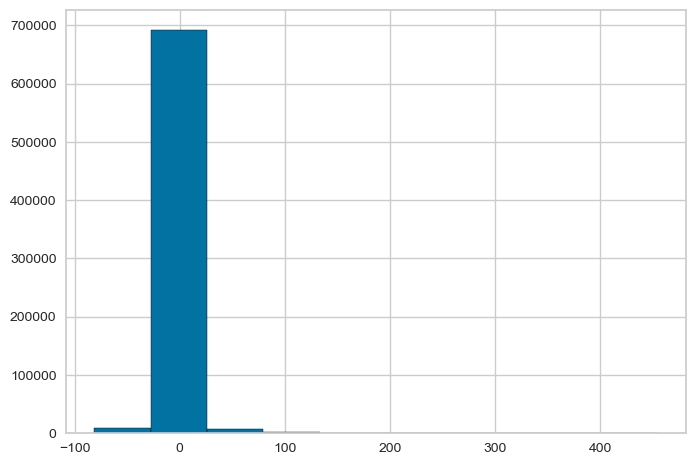

In [52]:
plt.hist(filtered_states['Ratio_Change_Top_Tier'], bins=10, edgecolor='black') 
filtered_states['Ratio_Change_Top_Tier'].describe()

count    713734.000000
mean          2.546563
std          29.217402
min         -90.891636
25%           0.000000
50%           0.000000
75%           0.000000
max        1086.227645
Name: Ratio_Change_Bottom_Tier, dtype: float64


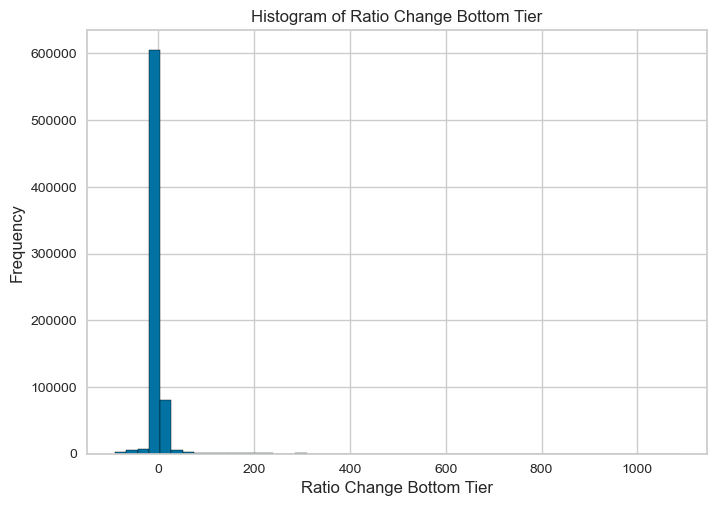

In [7]:
# Plot the histogram
plt.hist(filtered_states['Ratio_Change_Bottom_Tier'], bins=50, edgecolor='black') 

# Add labels and title
plt.xlabel('Ratio Change Bottom Tier')
plt.ylabel('Frequency')
plt.title('Histogram of Ratio Change Bottom Tier')

# Show descriptive statistics
print(filtered_states['Ratio_Change_Bottom_Tier'].describe())

# Show the plot
plt.show()

count    713734.000000
mean          0.820389
std           7.486190
min         -50.793651
25%           0.000000
50%           0.000000
75%           0.000000
max         139.516129
Name: Ratio_Change, dtype: float64

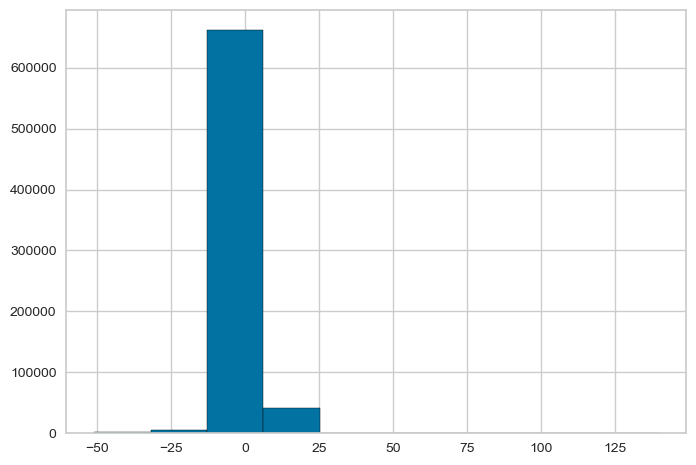

In [8]:
plt.hist(filtered_states['Ratio_Change'], bins=10, edgecolor='black') 
filtered_states['Ratio_Change'].describe()

In [9]:
# Get column names with object data types in Filtered States Dataframe
object_columns = filtered_states.select_dtypes(include=['object']).columns

# Drop the columns with object or geometry data types
filtered_states = filtered_states.drop(object_columns, axis=1)
filtered_states = filtered_states.drop(columns='geometry', axis=1)

In [18]:
#Looking at who has the highest ratio change for purchase price
top_ratio_changes = filtered_states.sort_values(by='Ratio_Change', ascending=False)
top_ratio_changes.head(50)

,Unnamed: 0,Year,Month,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),...,Loan-to-Price Ratio (%),Share of Total Market (%),ALAND,AWATER,INTPTLAT,INTPTLON,temperature_multiclass,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change
1838886,333366,2012,11,53527.928090,180680.374070,61.4,-2.3,63.7,1.0,2.96,...,67.0,13.3,1.507169e+09,9.811396e+08,28.850292,-82.595552,1,-5.930027,-4.296312,139.516129
2179578,333908,2012,11,74652.772428,251707.727449,59.9,2.1,57.8,1.0,2.96,...,67.0,13.3,2.031126e+09,4.474576e+07,30.743163,-95.569825,2,0.613073,1.087125,139.516129
2584176,333110,2012,11,109337.671333,334143.777016,49.9,-4.3,54.2,1.0,2.96,...,67.0,13.3,4.979375e+08,3.538039e+08,34.183445,-77.864204,1,-3.079360,-3.236562,139.516129
817688,332724,2012,11,131684.228017,346480.494256,41.7,5.1,36.6,1.0,2.96,...,67.0,13.3,2.066510e+09,1.979877e+07,39.644554,-104.331706,3,14.082428,8.749201,139.516129
1933312,333498,2012,11,70609.257574,210652.877549,56.6,1.6,55.0,1.0,2.96,...,67.0,13.3,7.080522e+08,6.206460e+06,32.486401,-94.816277,2,-0.730767,0.184332,139.516129
1202926,332820,2012,11,77791.703858,246492.060488,63.5,-2.3,65.8,1.0,2.96,...,67.0,13.3,1.638991e+09,1.996327e+07,35.158366,-96.602857,1,6.906256,6.295849,139.516129
2529636,333112,2012,11,154733.391532,378983.846703,37.5,1.7,35.8,1.0,2.96,...,67.0,13.3,5.459626e+09,1.027969e+09,48.842653,-121.836433,2,-0.783836,-0.582354,139.516129
1145082,332774,2012,11,55321.313482,227805.138228,46.0,-1.9,47.9,1.0,2.96,...,67.0,13.3,1.673033e+09,3.033720e+07,36.079065,-79.788665,1,3.277801,1.290634,139.516129
2396202,334972,2012,11,67517.041202,196801.254103,35.0,-1.3,36.3,1.0,2.96,...,67.0,13.3,1.610504e+09,1.167695e+07,42.591294,-74.438172,1,-0.875814,-0.320904,139.516129
2670616,333134,2012,11,61620.933815,212354.081327,36.5,-0.9,37.4,1.0,2.96,...,67.0,13.3,1.188509e+09,1.590816e+07,41.436636,-75.608768,1,-1.012477,3.581374,139.516129


In [19]:
#Looking at who has the highest ratio change for bottom tier average home value estimates
top_ratio_changes_bottom = filtered_states.sort_values(by='Ratio_Change_Bottom_Tier', ascending=False)
top_ratio_changes_bottom.head(50)

,Unnamed: 0,Year,Month,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),...,Loan-to-Price Ratio (%),Share of Total Market (%),ALAND,AWATER,INTPTLAT,INTPTLON,temperature_multiclass,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change
1188250,561701,2018,7,416260.797231,732922.008161,77.9,2.8,75.1,1.15,4.88,...,81.4,68.6,1.226850e+09,15575098.0,35.004636,-79.755695,2,1086.227645,416.529777,4.554865
1188246,561700,2018,7,416260.797231,732922.008161,77.9,2.8,75.1,1.30,4.39,...,64.8,6.1,1.226850e+09,15575098.0,35.004636,-79.755695,2,1086.227645,416.529777,0.670712
1188226,558211,2018,6,413629.881507,730007.863309,71.4,1.6,69.8,1.14,4.86,...,80.9,68.1,1.226850e+09,15575098.0,35.004636,-79.755695,2,1084.732238,416.205661,5.549983
1188222,558210,2018,6,413629.881507,730007.863309,71.4,1.6,69.8,1.20,4.38,...,66.6,5.1,1.226850e+09,15575098.0,35.004636,-79.755695,2,1084.732238,416.205661,-2.055434
1188274,565189,2018,8,418328.750565,735174.147581,78.4,5.2,73.2,1.15,4.87,...,81.0,70.2,1.226850e+09,15575098.0,35.004636,-79.755695,3,1075.841378,416.403696,5.254121
1188270,565188,2018,8,418328.750565,735174.147581,78.4,5.2,73.2,1.16,4.32,...,66.4,5.6,1.226850e+09,15575098.0,35.004636,-79.755695,3,1075.841378,416.403696,6.030151
1188202,554721,2018,5,410918.355360,727248.123895,66.1,5.5,60.6,1.13,4.82,...,81.4,68.8,1.226850e+09,15575098.0,35.004636,-79.755695,3,1069.051521,414.588692,5.666209
1188198,554720,2018,5,410918.355360,727248.123895,66.1,5.5,60.6,1.20,4.24,...,66.1,5.8,1.226850e+09,15575098.0,35.004636,-79.755695,3,1069.051521,414.588692,-0.327654
1188294,568678,2018,9,419711.820123,736319.292285,71.1,4.5,66.6,1.22,4.37,...,67.0,6.9,1.226850e+09,15575098.0,35.004636,-79.755695,3,1060.496741,414.948216,-0.032938
1188298,568679,2018,9,419711.820123,736319.292285,71.1,4.5,66.6,1.12,4.86,...,79.9,71.6,1.226850e+09,15575098.0,35.004636,-79.755695,3,1060.496741,414.948216,7.004161


In [20]:
#Looking at who has the highest ratio change for bottom tier average home value estimates
top_ratio_changes_top = filtered_states.sort_values(by='Ratio_Change_Top_Tier', ascending=False)
top_ratio_changes_top.head(50)

,Unnamed: 0,Year,Month,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),...,Loan-to-Price Ratio (%),Share of Total Market (%),ALAND,AWATER,INTPTLAT,INTPTLON,temperature_multiclass,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change
773452,584438,2019,1,135153.647469,6.369215e+05,35.6,1.0,34.6,1.43,4.43,...,67.3,6.0,2.558688e+09,32538317.0,44.324590,-90.799510,2,363.038293,455.110017,0.000000
773475,584439,2019,1,135153.647469,6.369215e+05,35.6,1.0,34.6,1.18,4.90,...,81.2,75.1,2.558688e+09,32538317.0,44.324590,-90.799510,2,363.038293,455.110017,0.000000
774096,587928,2019,2,135938.497694,6.360182e+05,43.8,7.2,36.6,1.27,4.20,...,67.8,6.7,2.558688e+09,32538317.0,44.324590,-90.799510,3,365.520609,453.210428,0.000000
774119,587929,2019,2,135938.497694,6.360182e+05,43.8,7.2,36.6,1.13,4.77,...,80.7,71.2,2.558688e+09,32538317.0,44.324590,-90.799510,3,365.520609,453.210428,0.000000
772808,580946,2018,12,134367.819567,6.363836e+05,38.8,2.8,36.0,1.16,4.52,...,65.6,6.0,2.558688e+09,32538317.0,44.324590,-90.799510,2,357.085278,451.381064,0.000000
772831,580947,2018,12,134367.819567,6.363836e+05,38.8,2.8,36.0,1.17,5.10,...,80.5,70.0,2.558688e+09,32538317.0,44.324590,-90.799510,2,357.085278,451.381064,0.000000
774740,591428,2019,3,136697.128219,6.341286e+05,42.9,-0.2,43.1,1.08,3.99,...,65.0,6.9,2.558688e+09,32538317.0,44.324590,-90.799510,2,364.798951,449.788504,0.000000
774763,591429,2019,3,136697.128219,6.341286e+05,42.9,-0.2,43.1,1.06,4.69,...,81.4,71.5,2.558688e+09,32538317.0,44.324590,-90.799510,2,364.798951,449.788504,0.000000
775384,594928,2019,4,137454.448188,6.335329e+05,53.9,2.4,51.5,1.21,3.97,...,68.7,7.1,2.558688e+09,32538317.0,44.324590,-90.799510,2,351.866544,438.548820,0.000000
775407,594929,2019,4,137454.448188,6.335329e+05,53.9,2.4,51.5,1.12,4.50,...,81.9,67.9,2.558688e+09,32538317.0,44.324590,-90.799510,2,351.866544,438.548820,0.000000


In [13]:
#Keeping these columns and converting to float
columns_to_float = ['ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON']
filtered_states[columns_to_float] = filtered_states[columns_to_float].astype(float)

# Get column names with object data types
object_columns = filtered_states.select_dtypes(include=['object']).columns

# Drop the columns with object or geometry data types
filtered_states = filtered_states.drop(object_columns, axis=1)

In [15]:
filtered_states.head()
filtered_states.dropna()

,Unnamed: 0,Year,Month,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),...,Loan-to-Price Ratio (%),Share of Total Market (%),ALAND,AWATER,INTPTLAT,INTPTLON,temperature_multiclass,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change
24,19022,2001,1,134011.292609,434953.121289,47.3,-0.5,47.8,0.57,7.69,...,55.9,7.7,1.051599e+10,1.785003e+09,34.196398,-118.261862,2,9.106132,8.685910,8.582949
25,19023,2001,1,134011.292609,434953.121289,47.3,-0.5,47.8,0.63,7.40,...,79.8,76.1,1.051599e+10,1.785003e+09,34.196398,-118.261862,2,9.106132,8.685910,13.009592
26,20648,2001,2,134495.031712,436357.668087,47.1,-2.4,49.5,0.53,7.23,...,58.4,11.8,1.051599e+10,1.785003e+09,34.196398,-118.261862,1,9.365314,8.909603,14.988426
27,20649,2001,2,134495.031712,436357.668087,47.1,-2.4,49.5,0.61,7.22,...,79.9,75.5,1.051599e+10,1.785003e+09,34.196398,-118.261862,1,9.365314,8.909603,17.348809
28,22276,2001,3,135191.995137,438477.032394,55.4,3.3,52.1,0.54,7.17,...,58.4,12.1,1.051599e+10,1.785003e+09,34.196398,-118.261862,2,9.478098,8.988295,17.015263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787417,589101,2019,2,74946.254418,248930.587758,50.1,2.1,48.0,1.13,4.77,...,80.7,71.2,5.072424e+08,1.912938e+07,32.974581,-94.979085,2,4.820173,4.361818,-1.570010
2787418,592592,2019,3,75624.558781,247202.166000,53.6,-1.5,55.1,1.08,3.99,...,65.0,6.9,5.072424e+08,1.912938e+07,32.974581,-94.979085,1,2.694984,2.383823,2.541604
2787419,592593,2019,3,75624.558781,247202.166000,53.6,-1.5,55.1,1.06,4.69,...,81.4,71.5,5.072424e+08,1.912938e+07,32.974581,-94.979085,1,2.694984,2.383823,-0.248216
2787420,596102,2019,4,76395.752707,245993.931642,63.2,-0.4,63.6,1.21,3.97,...,68.7,7.1,5.072424e+08,1.912938e+07,32.974581,-94.979085,2,0.899903,0.662420,3.769841


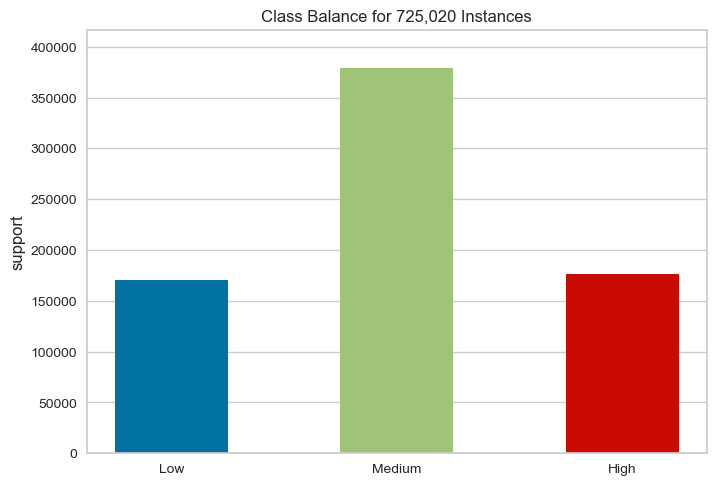

<Axes: title={'center': 'Class Balance for 725,020 Instances'}, ylabel='support'>

In [16]:
labels = ["Low", "Medium", "High"]

visualizer = ClassBalance(labels=labels)
visualizer.fit(filtered_states['temperature_multiclass'])

# Show the visualizer
visualizer.show()

In [6]:
#splitting the data 
seed = 7

X = filtered_states[filtered_states.columns.difference(['Purchase Price ($thou)'])]
y = filtered_states['temperature_multiclass']

# --- Splitting into train/test (75-25 ratio, random state = seed)----------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

print(y_test)

2496727    220.0
939067     248.0
1757885    228.7
446075     250.5
1518312    278.5
           ...  
648761     262.8
669526     288.4
2532027    196.4
958568     255.8
2427598    224.3
Name: Purchase Price ($thou), Length: 181255, dtype: float64


In [7]:
#  Using a SMOTE Approach to address class imbalance SMOTE

sm = SMOTE(random_state=17)

#Resample
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
sns.countplot(x=y_train_smote, tick_label=labels)
plt.show()

ValueError: Unknown label type: 'continuous'

## Exploring Models

1. Naive Bayes
2. Logistic Regression
3. Random Forests Classifier

### 1. Naive Bayes

In [18]:
# your code here
modelNB = GaussianNB()

#Training the model
modelNB.fit(X_train_smote, y_train_smote)

#Getting predictions
y_train_pred_NB = modelNB.predict(X_train_smote)
y_test_pred_NB = modelNB.predict(X_test)

#Print Confusion Matrix
print(confusion_matrix(y_test, y_test_pred_NB))

#Print the classification report
print(classification_report(y_test, y_test_pred_NB, target_names=labels))

[[36644  1883  3919]
 [78298  4969 11573]
 [36136  1648  6185]]
              precision    recall  f1-score   support

         Low       0.24      0.86      0.38     42446
      Medium       0.58      0.05      0.10     94840
        High       0.29      0.14      0.19     43969

    accuracy                           0.26    181255
   macro avg       0.37      0.35      0.22    181255
weighted avg       0.43      0.26      0.18    181255



### 2. Logistic Regression

In [20]:
# your code here
model_lr = LogisticRegression(max_iter=10000)

#Fitting the model to SMOTE
model_lr.fit(X_train_smote, y_train_smote)

#Getting predictions
y_train_pred_lr = model_lr.predict(X_train_smote)
y_test_pred_lr = model_lr.predict(X_test)

#Print Confusion Matrix
print(confusion_matrix(y_test, y_test_pred_lr))

#Print the classification report
print(classification_report(y_test, y_test_pred_lr, target_names=labels))

[[    0  7782 34664]
 [    0 19699 75141]
 [    0  8305 35664]]


/Users/yokokentilitisca/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yokokentilitisca/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         Low       0.00      0.00      0.00     42446
      Medium       0.55      0.21      0.30     94840
        High       0.25      0.81      0.38     43969

    accuracy                           0.31    181255
   macro avg       0.27      0.34      0.23    181255
weighted avg       0.35      0.31      0.25    181255



/Users/yokokentilitisca/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# your code here
# Step 1: Specify the parameters you want to explore in your model
parameters = {'C':[0.001, 0.01, 0.1, 1, 10], 'solver':('saga', 'newton-cg'), 'penalty': ("l1", "l2")}

# Step 2: Initialize a GridSearchCV object by passing your dtr model, parameters and cv=10
model_lr_grid_search = GridSearchCV(model_lr, param_grid=parameters, cv=5, scoring='recall_micro')

# Step 3: Train the GridSearchCV (it will build multiply models and return the best)
model_lr_grid_search.fit(X_train_smote, y_train_smote)

## Step 4: Print the best parameters
print(model_lr_grid_search.best_params_)

# Step 5: Save the best model into a separate variable to be used later
model_lr_gride_search_finetuned = model_lr_grid_search.best_estimator_

#Evaluating for fit
train_accuracy_lr = model_lr_gride_search_finetuned.score(X_train_smote, y_train_smote)
test_accuracy_lr = model_lr_gride_search_finetuned.score(X_test, y_test)

print("Train Accuracy:", train_accuracy_lr)
print("Test Accuracy:", test_accuracy_lr)